## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/NTR.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
5,2019-01-09,49.689999,49.689999,48.779999,49.410000,42.805553,1839700
6,2019-01-10,49.070000,50.080002,48.560001,50.049999,43.360012,1808100
7,2019-01-11,49.799999,50.139999,49.279999,49.869999,43.204067,826500
8,2019-01-14,49.430000,50.130001,49.200001,49.680000,43.039463,763400
9,2019-01-15,49.869999,50.160000,49.200001,49.669998,43.030800,898100


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...
2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400


## Describe Data

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03
mean,60.509250,61.375748,59.622357,60.495666,57.287847,2.081001e+06
std,18.418403,18.830872,18.005372,18.427809,19.364442,1.215053e+06
min,24.820000,26.750999,23.848000,25.100000,22.519356,4.274000e+05
25%,48.509998,48.952500,48.125000,48.495001,43.101965,1.296700e+06
50%,55.529999,55.950001,54.680000,55.349998,52.488567,1.757700e+06
75%,73.509998,74.610001,72.399998,73.380001,72.472850,2.568850e+06
max,113.760002,117.250000,111.910004,114.500000,111.642052,1.133740e+07


## Visualize Data

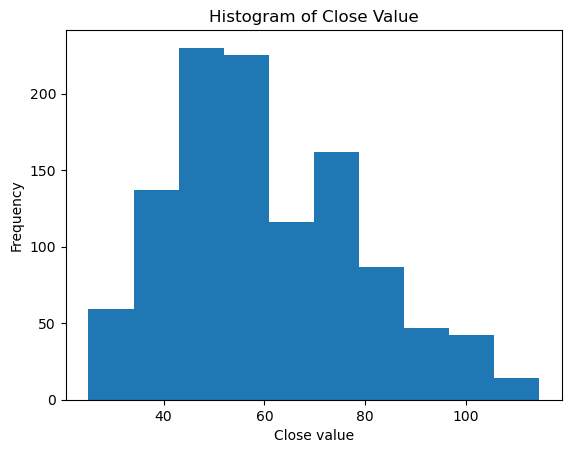

In [6]:
# Draw a histogram 
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

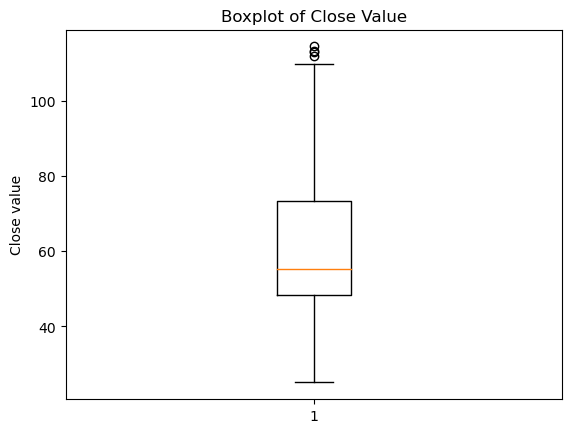

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Display boxplot
plt.show()

## Split the data into train, validation and test set with a ratio of 6 : 2 : 2

In [8]:
# Define the size of train, validation, test set
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

# Split the data into train, test and validation set
train_data = df.iloc[0 : train_size, :]
val_data = df.iloc[train_size : train_size + val_size, :]
test_data = df.iloc[train_size + val_size : len(df), :]

## Extracting features

Create function augment_features to calculate the fractional change in:
1. Opening and closing prices (fracocp)
2. High prices (frachp)
3. Low prices (fraclp)

In [9]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

Function extract_features will combine the 3 calculated fractional change into 1 array

In [10]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

## Build Model

In [11]:
# Set the quantity of hidden states is 10
model = GaussianHMM(n_components=10)

In [12]:
# Extract features of train set
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

# Training model
model.fit(features_train)

c:\Users\Admin\.conda\envs\user_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


GaussianHMM(n_components=10)

In [13]:
# Using 50 days in the past to predict the closing price of the current day
num_latent_days = 50

# Determine the number of days will be predicted is 30 days
num_days_to_predict = 30

## Evaluate in validation set

In [14]:
# Extract features of validation set
val_augmented = augment_features(val_data) 
val_fracocp = val_augmented['delOpenClose']
val_frachp = val_augmented['delHighOpen']
val_fraclp = val_augmented['delLowOpen']

# Divide validation set's feature values into parts
val_sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), 50) 
val_sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), 10)
val_sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), 10)

# Generate the possible permutations of values for the features of validation set
possible_outcomes = np.array(list(itertools.product(val_sample_space_fracocp, val_sample_space_frachp, val_sample_space_fraclp)))

In [15]:
# best_num_step stores the number of steps in the interval that the features take
best_num_step = None

# best_mae stores the best Mean Absolute Error value
best_mae = float('inf')

In [16]:
# Experiment and find the best number of steps between 10 and 50
for num_step in np.arange(10, 50, 10):
    sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    
    predicted_close_prices = []
    
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire validation data features for these days
        previous_data = extract_features(augment_features(val_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    
    # Calculate MAE value
    mae = (abs(val_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean()

    # Compare and find the best number of steps and the best MAE value
    if mae < best_mae:
        best_num_step = num_step
        best_mae = mae

 17%|█▋        | 5/30 [00:00<00:00, 35.66it/s]

100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


In [17]:
# Show the best number of steps
print("The best number of steps is : ", best_num_step)

The best number of steps is :  10


## Predict model with the best number of steps

In [18]:
# Extract features of test set
test_augmented = augment_features(test_data) 
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

# Divide test set's feature values into parts
sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), best_num_step) 
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(best_num_step/5))
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(best_num_step/5))

# Generate the possible permutations of values for the features of test set
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [19]:
y_pred = []

for i in tqdm(range(test_size - num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Calculate start and end indices
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) 
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    y_pred.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0])) 

100%|██████████| 195/195 [00:04<00:00, 45.75it/s]


## Calculate the error of the model

In [20]:
# Select the test values in reality
y_act = test_data.iloc[0 : test_size - num_days_to_predict]['Close']
y_act = y_act.values
y_act

array([ 79.269997,  78.32    ,  82.080002,  82.510002,  83.510002,
        83.410004,  85.660004,  83.660004,  82.169998,  81.889999,
        82.459999,  83.800003,  85.529999,  88.339996,  90.370003,
        90.519997,  92.379997,  89.389999,  91.449997,  91.639999,
        91.900002,  90.330002,  91.580002,  96.339996,  98.480003,
       101.690002, 100.410004,  99.019997,  94.040001,  91.769997,
        89.760002,  91.970001,  90.660004,  90.279999,  91.160004,
        95.059998,  90.919998,  89.599998,  91.779999,  88.849998,
        86.059998,  89.769997,  89.910004,  88.68    ,  88.169998,
        82.940002,  81.75    ,  84.639999,  87.050003,  83.580002,
        83.379997,  84.709999,  88.190002,  84.129997,  85.480003,
        83.739998,  85.080002,  82.510002,  82.75    ,  86.580002,
        77.919998,  79.730003,  81.900002,  81.699997,  82.589996,
        82.879997,  79.019997,  83.209999,  82.07    ,  83.400002,
        82.360001,  84.5     ,  85.779999,  82.980003,  71.309

In [21]:
# Select the test values in reality
test_mape = mean_absolute_percentage_error(y_act, y_pred)
test_mse = mean_squared_error(y_act, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_act, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.016843015253033996
RMSE on Test dataset:  1.7864545555051314
MSLE on Test dataset:  0.0004696394769237447


## Model visualization

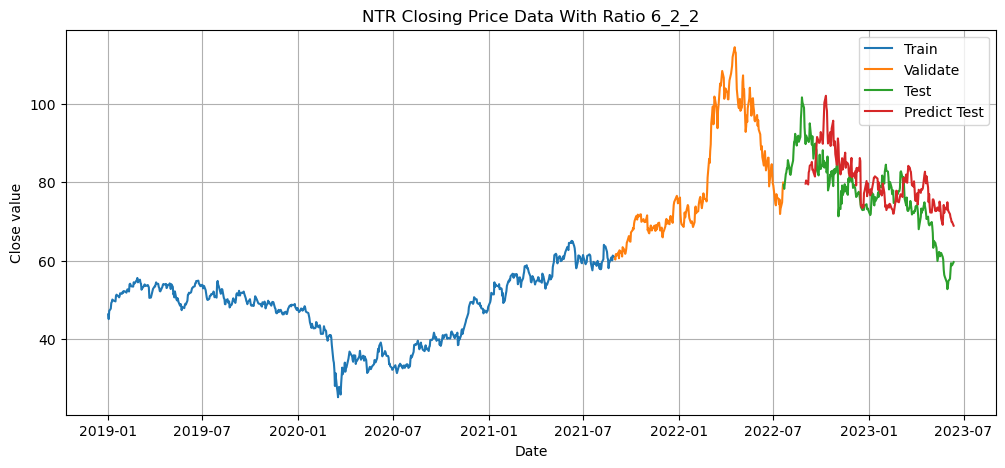

In [22]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data['Close'].values)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data['Close'].values)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data['Close'].values)

# Predict in test set
plt.plot(df[train_size + val_size + num_days_to_predict:].index, y_pred)

# Predict 30 next days
# plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict Test'])
plt.grid()
plt.title("NTR Closing Price Data With Ratio 6_2_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('HMM_622_NTR.png')
plt.show()